# Model

#### Preparation

In [1]:
import mmseg
print(mmseg.__version__)
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image
import time
%pwd

/home/ubuntu/.conda/envs/mmseg0/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


0.30.0


'/home/ubuntu/mmseg0/mmsegmentation'

#### Dataset Setting

In [2]:
data_root = 'data/IonoSeg/'
img_dir = 'rgbimg'
ann_dir = 'rgbmask'
split_dir = 'splits0'
label_dir = 'label'
classes = ('Background', 'E', 'Es-l', 'Es-c', 'F1', 'F2', 'Spread-F')
palette = [[230, 230, 230], [250, 165, 30], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [130, 20, 12], [120, 121, 80]]

In [3]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

#### Load Trained Model


In [4]:
from mmcv import Config
cfg = Config.fromfile('./work_dirs/se4ionogram/pspnet_r50_ionogram_mmseg0.py')
model_path = './work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth'

# initialize segmentor
model = init_segmentor(cfg,  model_path, device='cuda:0') 

/home/ubuntu/mmseg0/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ./work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth


#### Inference

/home/ubuntu/mmseg0/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


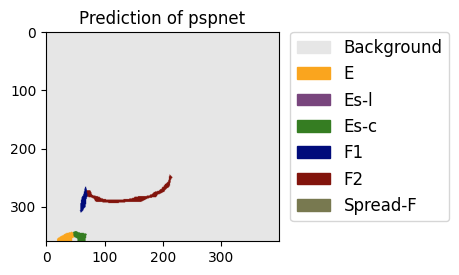

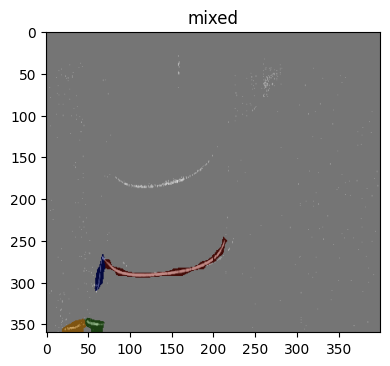

In [5]:
# test a single image
img = mmcv.imread(data_root + img_dir + '/20191106131500.png')
result = inference_segmentor(model, img)

# show result
plt.figure(figsize=(3,3))
plt.title('Prediction of pspnet')
seg_res = Image.fromarray(np.uint8(result[0])).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')

show_result_pyplot(model, img, result, fig_size=(4, 4), title='mixed')

### Functions

#### Load Data

```
[gimg, cimg, label, cmask, seg] = single_load(name)
```
@gimg, grayscale ionogram
@cimg, color ionogram
@seg, inference result
@label, grascale label
@cmask, color mask


In [6]:
import cv2
def single_load(name):
  label = cv2.imread(data_root + '/' + label_dir + '/' + name + '.png', cv2.IMREAD_GRAYSCALE) # 真实标签，gray ndarray
  cmask = Image.open(data_root + '/' + ann_dir + '/' + name + '.png')
  cimg = mmcv.imread(data_root + '/' + img_dir + '/' + name + '.png')  # numpy
  segs = inference_segmentor(model, cimg)
  gimg = cimg[:,:,0]  
  seg = segs[0]        
  return [gimg, cimg, label, cmask, seg]

#### Edge Detection and Feature Fusion 


```
segmap = post_seg(seg, cimg)
```



In [7]:
def post_seg(seg, cimg):
  blurred = cv2.GaussianBlur(cimg, (3, 3), 0)
  edge = cv2.Canny(blurred, 50, 150)
  edge = edge / 255
  # Hadamard product
  segmap = seg * edge
  return segmap

#### Obtain Parameters


```
[mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin] = interpret_numpy(segmap)
```



In [8]:
def interpret_numpy(segmap):
    [mhf2_pred, mff2_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin] = [-1] * 7
    indices = np.where(np.logical_or(segmap == 5, segmap == 6))
    if len(indices[0]) != 0:
        mhf2_pred = np.max(indices[0])
        mff2_pred = np.max(indices[1])

    indices = np.where(segmap == 1)
    if len(indices[0]) != 0:
        mhe_pred = np.max(indices[0])
        mfe_pred = np.max(indices[1])
    
    indices = np.where(segmap == 4)
    if len(indices[0]) != 0:
        mhf1_pred = np.max(indices[0])
        mff1_pred = np.max(indices[1])
    
    indices = np.nonzero(segmap)
    if len(indices[0]) != 0:
        fmin = np.min(indices[1])

    return [mhf2_pred, mff2_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin]

#### Visualization


```
show_cha_pyplot(cimg, cmask, segmap, palette,
                            mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred,
                            mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth):

```



In [9]:
def show_cha_pyplot(cimg, cmask, segmap, palette,
                                  mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                                  mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth):
  plt.figure(figsize=(28, 9))
  plt.subplot(131)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  plt.title('Input Image')
  plt.imshow(cimg)

  plt.subplot(132)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  plt.title('Ground Truth')
  plt.imshow(cmask)
  # f2
  plt.axvline(mf_truth,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_truth, -2,'foF2', color = 'g')
  plt.axhline(mh_truth,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_truth-3,'h\'F2', color = 'r')
  # E
  if mfe_truth > 0:
    plt.axvline(mfe_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_truth-6, -2,'foE', color = 'g')
    plt.axhline(mhe_truth,color='r',linestyle="--",alpha=0.8)
    plt.text(401, mhe_truth-3,'h\'E', color = 'r')
  # f1
  if mff1_truth > 0:
    plt.axvline(mff1_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_truth, -2,'foF1', color = 'g')
    plt.axhline(mhf1_truth,color='r',linestyle="--",alpha=0.8)  
    plt.text(401, mhf1_truth-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_truth-18, -2,'fmin', color = 'g')

  plt.subplot(133)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  plt.title('Final Prediction')
  seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
  seg_res.putpalette(np.array(palette, dtype=np.uint8))
  im = plt.imshow(np.array(seg_res.convert('RGB')))
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
  # f2
  plt.axvline(mf_pred,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_pred, -2,'foF2', color = 'g')
  plt.axhline(mh_pred,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_pred-3,'h\'F2', color = 'r')
  # E
  if mfe_pred > 0:
    plt.axvline(mfe_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_pred-6, -2,'foE', color = 'g')
    plt.axhline(mhe_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhe_pred-3,'h\'E', color = 'r')
  # f1
  if mff1_pred > 0:
    plt.axvline(mff1_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_pred, -2,'foF1', color = 'g')
    plt.axhline(mhf1_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhf1_pred-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_pred-18, -2,'fmin', color = 'g')
  # save as png
  # plt.savefig('results/'+str(cnt)+'.png')
  plt.show()

### Overview of the Model

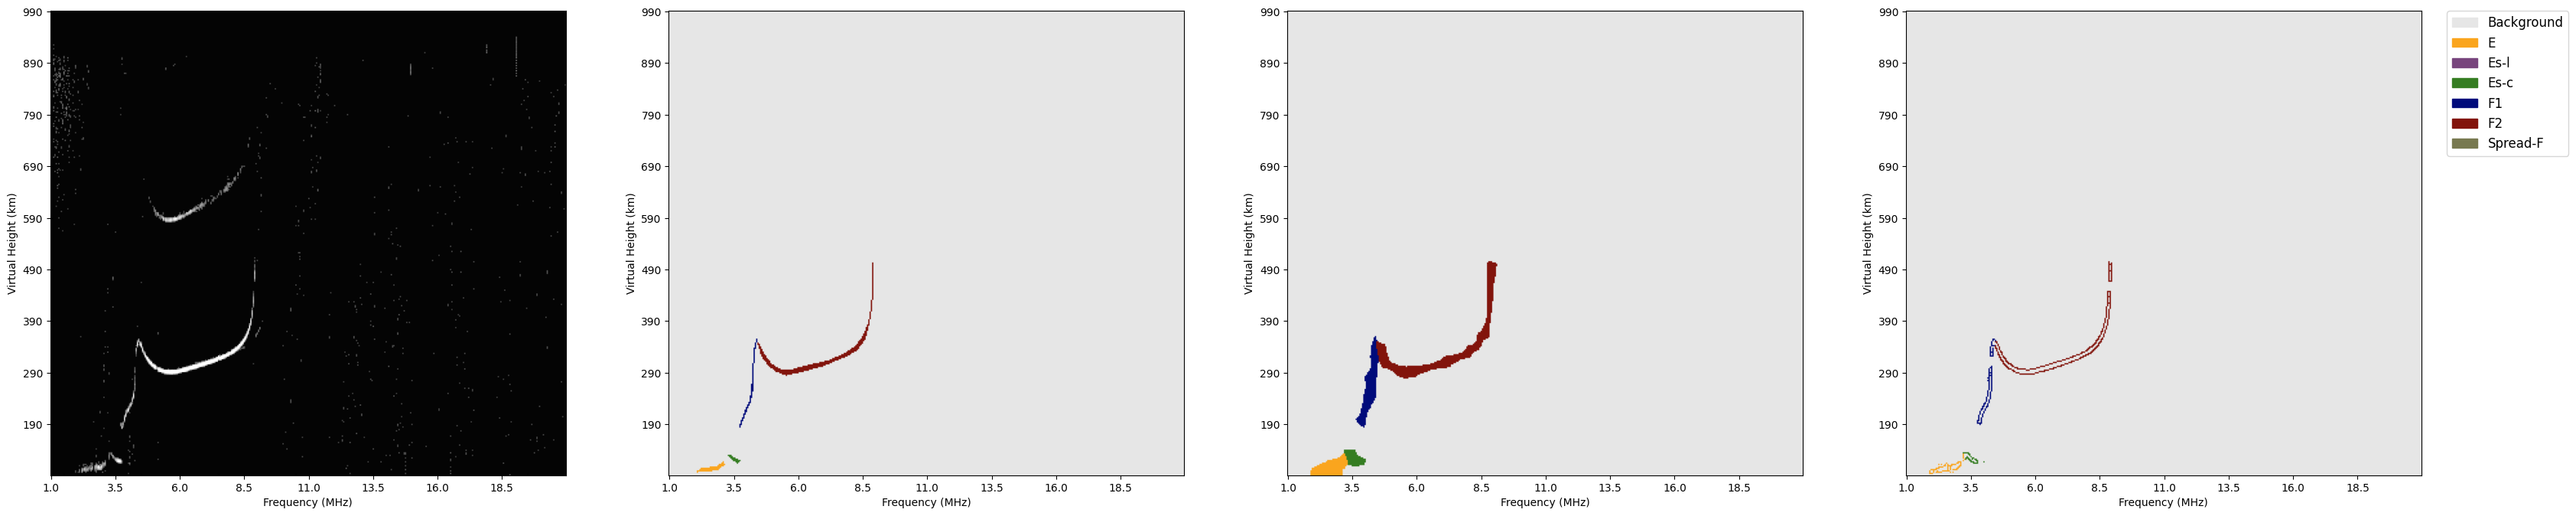

In [10]:
name_list=[]
with open(data_root + split_dir + "/test.txt", "r") as f:
	for line in f:
		name_list.append(''.join(line.strip('\n').split(',')))

name = name_list[780]
[gimg, cimg, label, cmask, seg] = single_load(name)

blurred = cv2.GaussianBlur(cimg, (3, 3), 0)
edge = cv2.Canny(blurred, 50, 150)
edge = 1 - edge / 255
segmap = seg * edge
segmap = post_seg(seg, cimg)

plt.figure(figsize=(40, 9))
plt.subplot(141)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Input Ionogram')
plt.imshow(cimg)
plt.subplot(142)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Edges of the trace')
plt.imshow(cmask)
# plt.imshow(edge, cmap='binary')
plt.subplot(143)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Prediction of segmentation networks')
seg_res = Image.fromarray(np.uint8(seg)).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.subplot(144)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Edge of each layer')
seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
plt.show()


# Evaluate

In [11]:
import os

cnt = 0
sample_interval = 1
tic1  = time.perf_counter()
N = len(name_list)

list_pred = []
list_target = []

# for name in name_list:
while cnt < N:
  name = name_list[cnt]
  [gimg, cimg, label, cmask, seg] = single_load(name)
  segmap = post_seg(seg, cimg) 

  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred] = interpret_numpy(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth] = interpret_numpy(label)

  list_pred.append([mh_pred, mf_pred-1, mhe_pred, mfe_pred-1, mhf1_pred, mff1_pred-1, fmin_pred+1])
  list_target.append([mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth])
  
  if cnt % 100 == 0:
    tic2  = time.perf_counter()
    print(cnt, '/', N, 'time:', tic2-tic1, 's')

  cnt = cnt + sample_interval

cha_pred = np.array(list_pred)
cha_target = np.array(list_target)

os.makedirs('./work_dirs/npz', exist_ok=True)
np.save('./work_dirs/npz/pred.npy', cha_pred)
np.save('./work_dirs/npz/target.npy', cha_target)

0 / 863 time: 0.04702200973406434 s
100 / 863 time: 4.5696579329669476 s
200 / 863 time: 8.987749606836587 s
300 / 863 time: 13.433478919789195 s
400 / 863 time: 17.944624623749405 s
500 / 863 time: 22.410476059652865 s
600 / 863 time: 27.16534982388839 s
700 / 863 time: 31.63654029602185 s
800 / 863 time: 36.25833696871996 s


In [14]:
import numpy as np

cha_pred = np.load('./work_dirs/npz/pred.npy')
cha_target = np.load('./work_dirs/npz/target.npy')

# mh_f2,  mf_f2,  mh_e,  mf_e,  mh_f1, mf_f1
dh = 0
df = 0
list_dF2 = []
list_d = []   #[i, j, dh, df]    @i: image number @j: {0: f2; 2: e; 4: f1; 6:fmin}
list_dfmin = []
cnt = 0
for i in range(N):
  for j in [0,2,4]:
    if ((cha_pred[i][j] != -1) & (cha_target[i][j] != -1)):    
      list_d.append([i, j, (-cha_pred[i][j] + cha_target[i][j]), (cha_pred[i][j+1] - cha_target[i][j+1])])
      if j == 0:
        list_dF2.append([-cha_pred[i][j] + cha_target[i][j], cha_pred[i][j+1] - cha_target[i][j+1]])

dev = np.array(list_d)
list_dfmin = []

for i in range(N):
  if ((cha_pred[i][6] != -1) & (cha_target[i][6] != -1)):   
    list_dfmin.append(cha_pred[i][6] - cha_target[i][6])

dfmin = np.array(list_dfmin)
dfmin = 0.05*dfmin    

list_dF2 = np.array(list_dF2)
dfoF2 = list_dF2[:,1] * 0.05
dhF2 = list_dF2[:,0] * 2.5

dh = 2.5*dev[:,2]
df = 0.05*dev[:,3]
df = np.concatenate((df, dfmin), axis=None)

cnt = 0
for i in range(len(dhF2)):
  if(abs(dhF2[i]) > 10):
    cnt = cnt + 1
print('dhF2 <= 10km:', 1-cnt/len(dhF2))
for i in range(len(dfoF2)):
  if(abs(dfoF2[i]) > 0.2):
    cnt = cnt + 1
print('dfoF2 <= 0.2MHz:', 1-cnt/len(dfoF2))

print('\nmean absolute DH', np.mean(abs(dh)))
print('mean absolute DF', np.mean(abs(df)) )
print('\nmean DH', np.mean(dh))
print('mean DF', np.mean(df))

dhF2 <= 10km: 0.9872537659327926
dfoF2 <= 0.2MHz: 0.9779837775202781

mean absolute DH 2.8216739537788884
mean absolute DF 0.0838676948051948

mean DH -0.25452841973766394
mean DF -0.023559253246753252


# Visualization

0


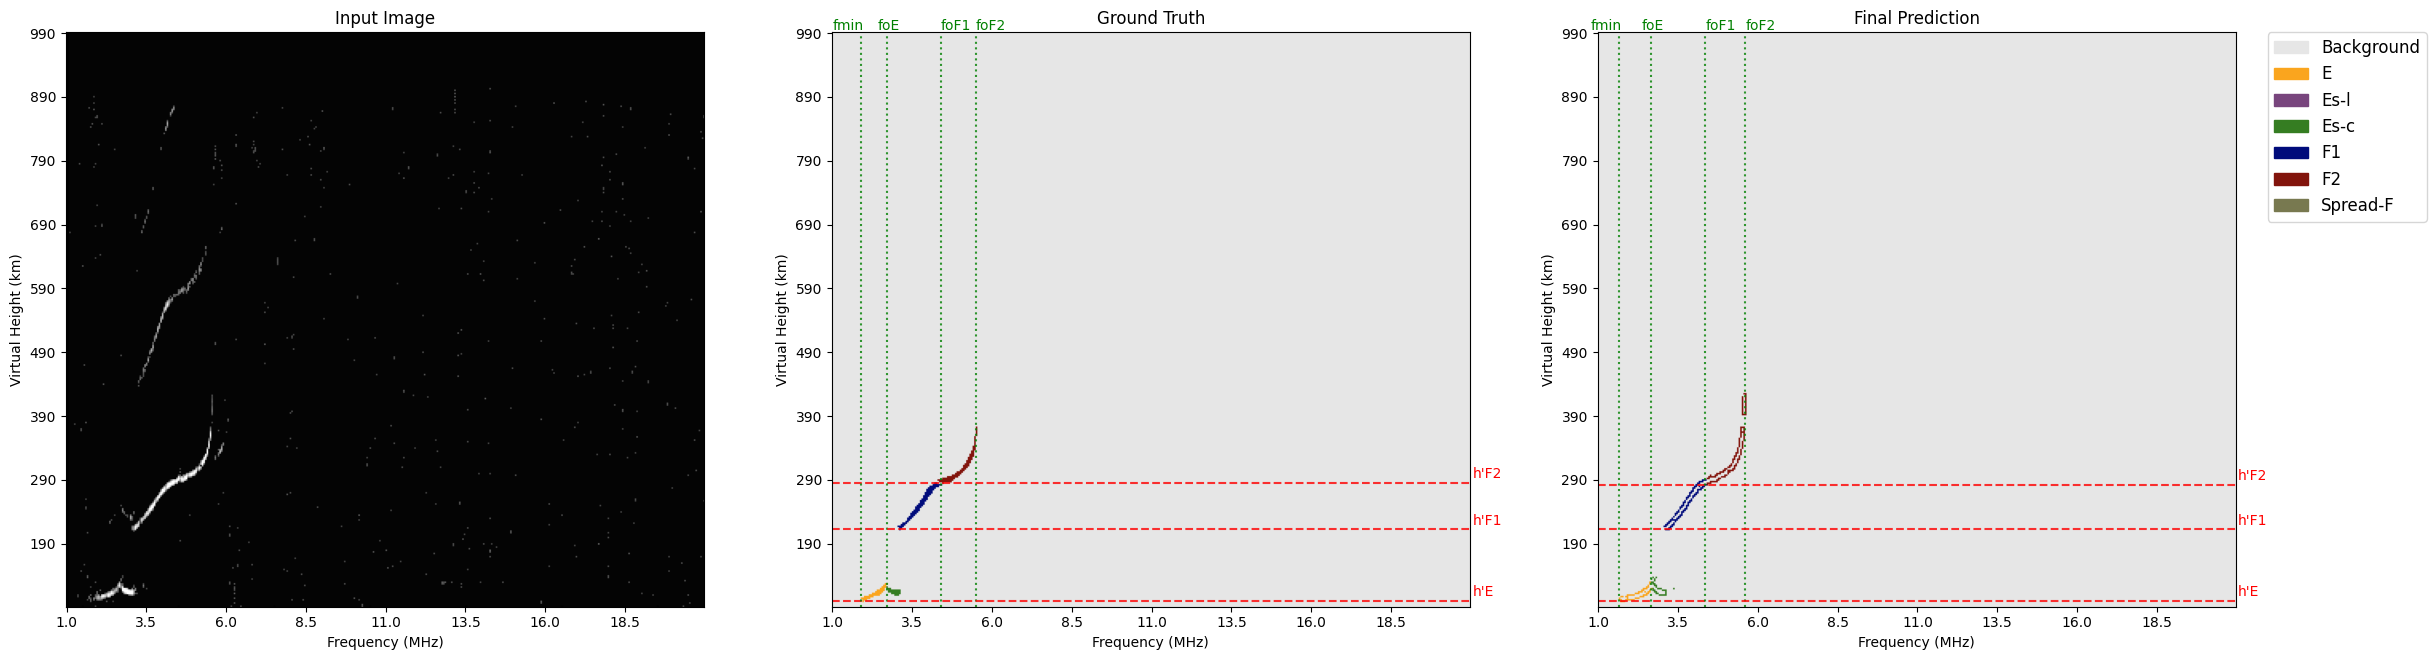

In [13]:
cnt = 0
sample_interval = 1000
N = len(name_list)

list_pred = []
list_target = []

# for name in name_list:
while cnt < N:
  name = name_list[cnt]
  [gimg, cimg, label, cmask, seg] = single_load(name)
  segmap = post_seg(seg, cimg) 
  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred] = interpret_numpy(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth] = interpret_numpy(label)

  print(cnt)
  show_cha_pyplot(cimg, cmask, segmap, palette,
                                  mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                                  mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth)
  cnt = cnt + sample_interval